In [1]:
%config InlineBackend.figure_format = "svg"
%matplotlib inline

# Deutsch Jozsa's Algorithm

This algorithm was one of the first to take advantage of Quantum Computing to demonstrate that it can perform some tasks more efficiently than Classical Computers.

This algorithm is at the heart of a simple question: Say we have a function $f$ that maps an $n$ bit string into a single bit:
$f: \{0, 1\}^n \mapsto \{0, 1\}$

The purpose of the algorithm is therefore to determine if this function is **balanced** or **constant**. Balanced means that the number of bit strings that $f$ maps to $0$ is the same number that it maps to $1$. Constant means that the function has the same output for every possible input.

# Classical Approach

Before diving into the Quantum Algorithm, it is a good exercise to understand how one could implement this classically, so that we can later compare the two methods more easily.

To do this is a classical manner, we have to evaluate $f$ for each possible bit string and count the number of times each result happens.

Here we consider the functions:
- Balanced: $f(x) = x \% 2$
- Constant: $f(x) = 1$

In [2]:
balanced_f = lambda x: int(x) % 2
constant_f = lambda x: 1

def isBalanced(func, n):
    """
    Verifies if func is balanced or constant
    
    Args:
        - func: The function to be tested
        - n: The number of bits of the bitstrings to be used
    """
    
    total = 2**n
    num_ones = sum([func(x) for x in range(total)])
    
    if num_ones == total / 2:
        print("Function is balanced")
    elif num_ones == total or num_ones == 0:
        print("Function is constant")
    else:
        print("Function is neither")

print ("f(x) = x % 2 --> ", end="")
isBalanced(balanced_f, 16)
print ("f(x) = 0     --> ", end="")
isBalanced(constant_f, 16)

f(x) = x % 2 --> Function is balanced
f(x) = 0     --> Function is constant


Since we have to iterate every since possible bitstring in the function's domain, and since for an $n$ bit bitstring (with no sign bit) we can represent $2^n$ numbers (including zero), the time complexity of this function is:

$$ T(n) = 2^n \Leftrightarrow T(n) \in \Theta(2^n) $$

# Quantum Approach

The key point is that quantum mechanics can test **every single bitstring at the same time** using one of it's fundamental properties: **Superposition**

By using superposition, we can evolve every single possible bitstring, represented by QuBits instead of CBits, and make them interfere so that we can determine wether $f$ is balanced or not.

Let's take a look at the algorithm's circuit and explain the mathematics behing it:

In [3]:
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit_textbook.tools import array_to_latex
from qiskit import *
import numpy as np

n = 8

## Qiskit Circuit implementation

First I am writing the code for generating the unitary Oracle matrix that will be introduced in our circuit. This won't make much sense for now, so I advise ignoring this part and checking back later if you are curious how to do this. It is also probably the trickiest part of the code, specially because you might not know, but `Qiskit` uses the **little endian** convention for both its classical and quantum registers.

In [4]:
def set_bit(value, bit):
    return value | (1<<bit)

def clear_bit(value, bit):
    return value & ~(1<<bit)

def newBitString(func, x, n):
    r = func(clear_bit(x, n-1))
    msb = int(bin(x)[2:].zfill(n)[0])
    if r==1 and not msb: x = set_bit(x, n-1)
    elif r==1 and msb: x = clear_bit(x, n-1)
    return x

def unitaryMatrix(func, n):
    """
    Calculates the unitary Oracle matrix
    Important Note: Qiskit uses Little Endian convention
    """
    total = 2**(n+1)
    v = np.array([newBitString(func, x, n+1) for x in range(total)])
    r = np.zeros((v.size, v.size))
    r[np.arange(v.size), v] = 1
    
    # Verify that the matrix is unitary
    assert np.array_equal(np.matmul(r, r.T), np.identity(v.size))
    
    return r.T

In this part of the code I generate the circuit and plot it. It might be best to check the theoretical description first and then check this code, because for now I have not motivated it. It is just easier to explain the circuit when it is already drawn.

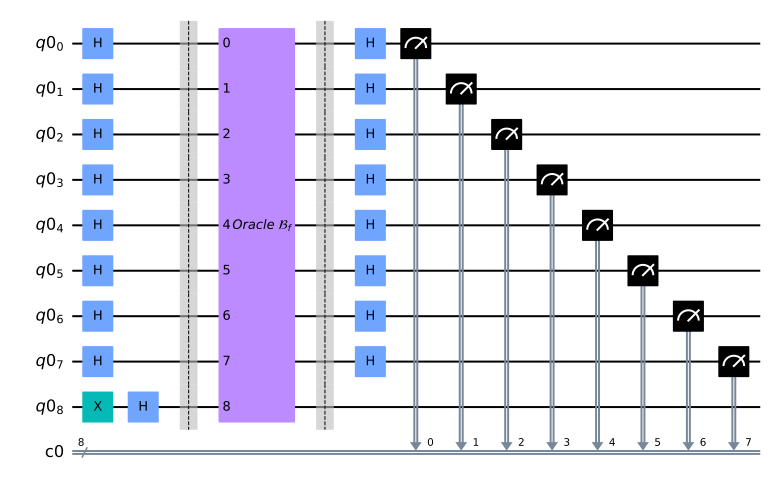

In [5]:
def DeutschJozsa(func, n):
    # Create registers and circuit
    qr, cr = QuantumRegister(n+1), ClassicalRegister(n)
    circuit = QuantumCircuit(qr, cr)
    # Populate the circuit
    circuit.x(n)
    circuit.h(range(n+1))
    circuit.barrier()
    circuit.unitary(unitaryMatrix(func, n), range(n+1), label="$ \qquad Oracle \; \mathcal{B}_f \qquad $")
    circuit.barrier()
    circuit.h(range(n))
    circuit.measure(range(n), range(n))
    
    return circuit

DeutschJozsa(balanced_f, n).draw(output="mpl")

## Theory Description

Before the first barrier, what we have is $n$ QuBits with in the state $|0\rangle$ and $1$ QuBit in the state $|1\rangle$, all going through Hadamard gates. If we name $|\psi_1\rangle$ the state that represents the combination of all these states:

$$ |\psi_1\rangle = \left( \bigotimes_{i=1}^{n} H |0\rangle \right) \otimes H |1\rangle = \left( \bigotimes_{i=1}^{n} \frac{1}{\sqrt{2}} \big( |0\rangle + |1\rangle \big) \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

After the barrier, we introduce a costum gate $\mathcal{B}_f$. This gate will keep every one of the first $n$ QuBits unchanged, but will modify the last QuBit:

$$ \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) $$

To simplify the expression above, we can notice that $f(x)$ can only output two values:
 
 $$ f(x) = 0 \rightarrow \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} \big( |0 \rangle - |1 \rangle \big) $$
 
 $$ f(x) = 1 \rightarrow \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} \big( |1 \rangle - |0 \rangle \big) = - \frac{1}{\sqrt{2}} \big( |0 \rangle - |1 \rangle \big) $$
 
Therefore we can reexpress the last qubit as:
 
$$ \frac{1}{\sqrt{2}} \big( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \big) = \frac{1}{\sqrt{2}} (-1)^{f(x)} \big( |0 \rangle - |1 \rangle \big)  $$

And we can rewrite the effect of $B_f$ on $|\psi_1\rangle$ and call the resulting state $|\psi_2\rangle$:

$$ \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} (-1)^{f(x)} \big( |0\rangle - |1\rangle \big) $$

$$ |\psi_2\rangle = \mathcal{B}_f |\psi_1\rangle = \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} |x\rangle \right) \otimes \frac{1}{\sqrt{2}} \big( |0\rangle - |1\rangle \big) $$

This manipulation, where this Quantum gate seems to only affect the *state* of one QuBit, but can also be expressed as only affecting the *phases* of every other QuBit, is very common and useful in many Quantum Computing algorithms and is known as the **phase kickback**.

Finally, to get the final state, we just discard the last QuBit and once again apply Hadamard gates to all the remaining ones. By using the identity:

$$ H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2}} \sum_{y \in \{0, 1\}^n} (-1)^{x \cdot y} |y\rangle \;, \quad x \cdot y = \sum_{i=1}^{n} x_i y_i $$

We can determine the final state $|\psi_3\rangle$:

$$ |\psi_3\rangle = H^{\otimes n} \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} |x\rangle \right) = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} \left( \frac{1}{\sqrt{2}} \sum_{y \in \{0, 1\}^n} (-1)^{x \cdot y} |y\rangle \right) $$

$$ |\psi_3\rangle = \frac{1}{2^n} \sum_{y \in \{0,1\}^n} \left( \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot y} \right) |y\rangle $$

How does this complicated quantum state help us, exactly?
Well, at the end of the day, what we want to do is take a measurement of the final state to get our final answer. To get aditional information out of this final quantum state, we must calculate measurement probabilities!
It turns out that what we are interested in is the probability that $|\psi_3\rangle$ is a bitstring containing all zeros. If we define $|\phi\rangle = |0\rangle^{\otimes n}$ (a zero bitstring), then the probability of measuring all zeros is given by:

$$ P_{\phi} = |\langle\phi|\psi_3\rangle|^2 = \left| \; \frac{1}{2^n} \sum_{y \in \{0,1\}^n} \left( \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot y} \right) \langle\phi|y\rangle \; \right|^2 = \left| \; \frac{1}{2^n} \sum_{x \in \{0,1\}^n} (-1)^{f(x) + x \cdot \phi} \; \right|^2 $$

But since we defined:

$$ x \cdot y = \sum_{i=1}^{n} x_i y_i $$

Then $ x \cdot \phi = 0 $ and the probability becomes:

$$ P_{\phi} = \left| \; \frac{1}{2^n} \sum_{x \in \{0,1\}^n} (-1)^{f(x)} \; \right|^2 $$

And finally, we just have to notice that:
- If $f$ is balanced:

$$ \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} = \sum_{i=1}^{2^{n-1}} 1 - \sum_{j=1}^{2^{n-1}} 1 = 0 $$

- And if $f$ in constant:

$$ \sum_{x \in \{0, 1\}^n} (-1)^{f(x)} = ± \sum_{i=1}^{2^n} 1 = ± 2^n $$

Therefore:

$$ f \; \mathtt{is} \; \mathtt{balanced} \rightarrow P_{\phi} = 0 $$
$$ f \; \mathtt{is} \; \mathtt{constant} \rightarrow P_{\phi} = 1 $$

The bottom-line of this Algorithm is that, given the appropriate Oracle, this Algorithm can determine whether a function is constant or balanced in **one go**, with only one run through the circuit! This means that, no matter how many bits $n$ we consider, the time complexity of this algorithm is:

$$ T(n) \in \Theta(1) $$

Which is an **exponential** speed up when compared to the Classical Algorithm!

## Simulation using Qiskit Aer

Finally we can simulate this and check that the results indeed match with the theory. For the constant function:

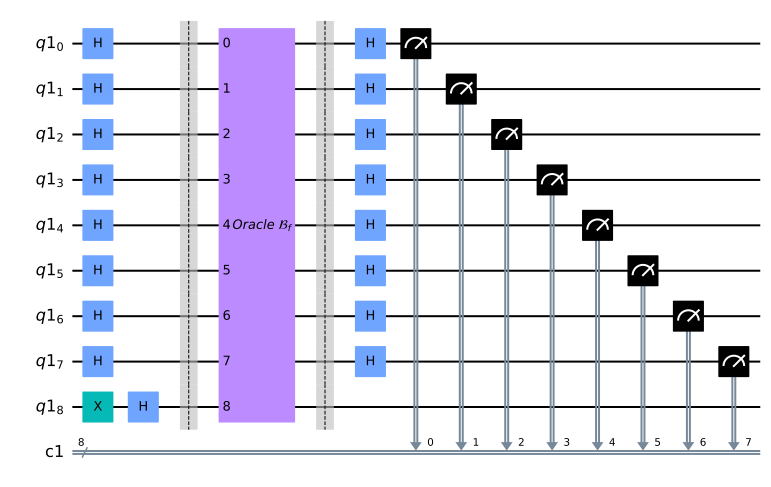

In [6]:
circuit = DeutschJozsa(constant_f, n)
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1024).result()
circuit.draw(output="mpl")

Now plotting the results, we see that this circuit returns the state $|0\rangle^{\otimes n}$ with probability 1:

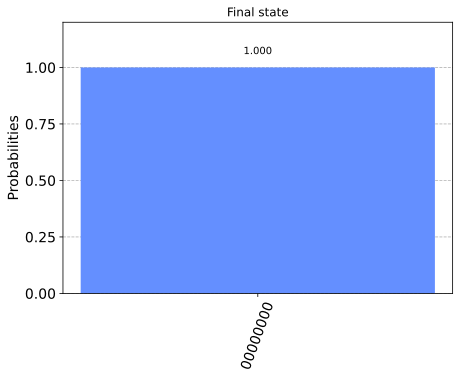

In [7]:
plot_histogram(result.get_counts(circuit), title="Final state")

And finally we can also perform a simulation on a balanced function:

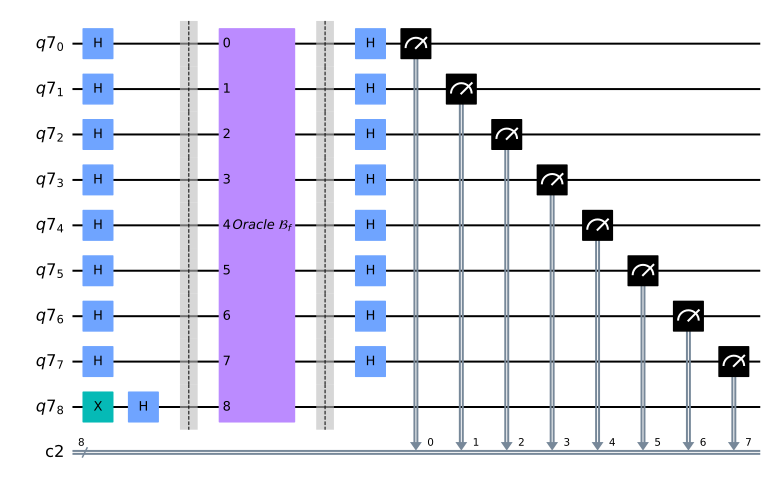

In [8]:
circuit = DeutschJozsa(balanced_f, n)
simulator = Aer.get_backend("qasm_simulator")
result = execute(circuit, backend=simulator, shots=1024).result()
circuit.draw(output="mpl")

Where, as we can see, the probability of the final statevector being $|0\rangle^{\otimes n}$ is 0:

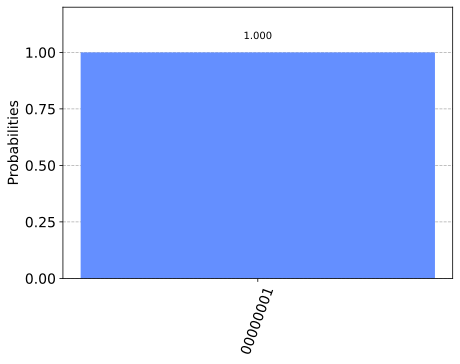

In [9]:
plot_histogram(result.get_counts(circuit))

## How to construct the Oracle Matrix

As you might know from linear algebra, you can always generate a matrix from the way it acts on your basis vectors. Here, the basis vectors are the computational basis of $n$ bits: $\{0, 1\}^{n+1}$. Notice that it we are now using $n+1$ QuBits instead of $n$ due to the added QuBit we need to perform the Deutsch Jozsa Algorithm.

Therefore, the process of constructing the matrix is as follows:
- Calculate the statevector outcome of the matrix when applied to a statevector
- That result will be a column of the matrix

Or, defining this mathematically:

$$ \mathcal{B}_f |0\rangle^{\otimes n} = |x_0\rangle $$

$$ \mathcal{B}_f |0\rangle^{\otimes n-1} \otimes |1\rangle = |x_1\rangle $$

$$ \dots $$

$$ \mathcal{B}_f |1\rangle^{\otimes n} = |x_{2^n-1}\rangle $$

Let entry $j$ of statevector $|x_i\rangle$ be denoted by $x_{ij}$ and $N = 2^n-1$. Then:

$$ \mathcal{B}_f = \left[ {\begin{array}{cc}
   x_{00} & x_{10} & \dots & x_{N0}\\
   x_{01} & x_{11} & \dots & x_{N1}\\
   \dots & \dots & \dots & \dots \\
   x_{0N} & x_{1N} & \dots & x_{NN} \\
  \end{array} } \right] $$
  
Now, a **very important** thing to note is that `Qiskit` uses the **little endian** convention. This means that, contrary to the theory description above, the last QuBit of the circuit is defined as the **most significant** bit (the one on the left).

Take the example where the last QuBit (the one at the bottom of the Quantum Circuit above) is $|1\rangle$ and every other QuBit is $|0\rangle$. In the notation of the theory description, this would be represented as $|00\dots1\rangle$, but in `Qiskit` it should be represented as $|100\dots0\rangle$.

Now suppose that we consider the constant function $f(x) = 1$ for $2$ bits. The $4$-th ($4_2 = 100$) collumn of this matrix (using `Qiskit` convention) is therefore given by:

$$ \mathcal{B_f} |100\rangle = |1 \oplus f(00)\rangle \otimes |00\rangle = |000\rangle = \left[
\begin{array}{c}
1 \\
0 \\
0 \\
\end{array} \right] $$